## Heuristic operation strategy

This alternative makes use of a rule-based approach to decide when to start and
stop the subsystems based on threshold values of the solar irradiance and the
thermal storage state of charge. The rules are defined as follows:

- Start solar field operation when the solar irradiance exceeds a
    predefined threshold ($I_{\uparrow}=500$~W/m$^2$). Stop operation when it
    falls below a lower threshold ($I_{\downarrow}=400$~W/m$^2$).
    
- Start thermal storage charging when the solar field outlet temperature
    exceeds the one of the (top) hot tank: $T_{sf,out} > T_{ts,h,t}$. Stop
    charging when the solar field outlet temperature falls below the hot tank
    temperature: $T_{sf,out} < T_{ts,h,t}$.
    
- Start \gls{medLabel} operation when the thermal storage is above
    76~$^\circ$C. Stop operation when it falls below 65~$^\circ$C.

As for the continuous decision variables:

- The \gls{medLabel} operates fixed
    setpoints at nominal conditions: $T_{med,s,in}=74$~$^\circ$C,
    $q_{med,f}=8$~m$^3$/h, $q_{med,s}=12$~l/s, $T_{med,c,out}=28$~$^\circ$C. 
    
- The solar field recirculation flow rate is set to maintain the solar
    field outlet temperature at 90~$^\circ$C. 
    
- The thermal storage recirculation flow rate is set to maximize the
    heat transfer from the solar field while keeping the inlet hot tank
    temperature above its current value to avoid colder water mixing.
    
    $\max_{q_{ts,src};e;\Theta}{\dot{Q}_{ts,src}}$
    
    $\text{subject to:} \quad  T_{ts,h,in} > \min\left(T_{ts,h,t},\, 90^\circ\text{C}\right)$


In [7]:
from pathlib import Path
import datetime
from typing import Optional
import numpy as np
from tqdm.auto import tqdm  # notebook compatible

from solarmed_modeling.solar_med import InitialStates
from solarmed_optimization import (ProblemParameters,
                                   IrradianceThresholds,
                                   EnvironmentVariables,
                                   DecisionVariables,
                                   MedMode,
                                   med_fsm_inputs_table)
from solarmed_optimization.utils.initialization import problem_initialization
from solarmed_optimization.utils.serialization import export_simulation_results

%load_ext autoreload
%autoreload 2

base_path = Path("/workspaces/SolarMED")
env_date_span: tuple[str, str] = ("20180921", "20180928")
evaluation_id: str = "dev"

file_id: str = f"results_eval_at_{datetime.datetime.now():%Y%m%dT%H%M}_{evaluation_id}"
output_path: Path = Path(base_path) / f"optimization/results/{env_date_span[0]}_{env_date_span[1]}/heuristic/{file_id}.h5"

output_path.parent.mkdir(parents=True, exist_ok=True)

data_path = base_path / "optimization/data"
# uncertainty_factor: float = 0
debug_mode = True

irradiance_thresholds = IrradianceThresholds(
    upper=500,  # W/m2
    lower=400   # W/m2
)

# Sample time is the same as the model time step
sample_time: int = 400  # seconds


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Initialize model with inital state all subsystems inactive

problem_params = ProblemParameters(
    strategy_id="heuristic",
    sample_time_mod= sample_time,
    on_limits_violation_policy="clip",
    irradiance_thresholds=irradiance_thresholds,
    initial_states=InitialStates.initialize_from_inactive_state(),
    # We are using default values for the rest of the parameters,
    # this is assuming the other alternatives also do so:
    # env_params
    # fixed_model_params
    # model_params
    # fsm_params
    # fsm_valid_sequences
)

env_date_span_str: str = f"{env_date_span[0]}_{env_date_span[1]}"
start_date = datetime.datetime.strptime(date_span[0], "%Y%m%d").replace(hour=0).astimezone(tz=datetime.timezone.utc)
end_date = datetime.datetime.strptime(date_span[1], "%Y%m%d").replace(hour=23).astimezone(tz=datetime.timezone.utc)

problem_data = problem_initialization(
    problem_params=problem_params, 
    date_str=env_date_span_str, 
    data_path=data_path,
    selected_date_span=(start_date, None),
)

# Environment variables used for the simulation
env_vars = EnvironmentVariables.from_dataframe(
    problem_data.df, 
    cost_w=problem_params.env_params.cost_w,
    cost_e=problem_params.env_params.cost_e
)
model = problem_data.model
df_env = problem_data.df
df_mod = None

med_nominal_dvs = dict(
    qmed_s = 12*3.6, # l/s -> m3/h
    qmed_f = 8, # m3/h
    Tmed_s_in = 74.0, # °C
    Tmed_c_out = 28.0, # °C
)
Tsf_out_nominal = 90.0  # °C
Tmed_s_in_min = 65.0  # °C
Tmed_s_startup = 76.0  # °C
qts_max_step = 1.0  # maximum change per control step, m³/h

qsf_vals = np.linspace(model._fmp.sf.qsf_min, model._fmp.sf.qsf_max, 5)
qts_src_vals = np.linspace(model._fmp.ts.qts_src_min, model._fmp.ts.qts_src_max, 10)


2025-10-31 16:54:57.060 | WARNING  | solarmed_optimization.utils.initialization:problem_initialization:109 - External environment data (20220524 - 20240524) (seawater temperature and salinity) is not available for the data period (20180921 - 20180928). Using data for same month and days but from closest year 2022.
2025-10-31 16:54:57.068 | INFO     | solarmed_optimization.utils.initialization:problem_initialization:121 - Selected date span: 2018-09-21 00:00:00+00:00 - None from 2018-09-21 05:00:00+00:00 - 2018-09-28 00:00:00+00:00
2025-10-31 16:54:57.068 | INFO     | solarmed_optimization.utils.initialization:problem_initialization:121 - Selected date span: 2018-09-21 00:00:00+00:00 - None from 2018-09-21 05:00:00+00:00 - 2018-09-28 00:00:00+00:00


In [4]:
# Simulation block
current_state = model.current_state
sf_active = False
med_active = False

pbar = tqdm(range(len(df_env)), desc="SolarMED | Heuristic strategy", unit="", leave=True, position=0)
for step_idx in pbar:
    timestamp = df_env.index[step_idx]
    pbar.set_postfix({"Current sample": timestamp.strftime("%Y%m%d %H:%M")})
    
    ev: EnvironmentVariables = env_vars.dump_at_index(step_idx)

    # Set operational states
    # Solar field activation/deactivation based on irradiance thresholds with hysteresis
    if ev.I >= irradiance_thresholds.lower:
        sf_active = sf_active or (ev.I >= irradiance_thresholds.upper)
    else:
        sf_active = False
    
    # Thermal storage should be inactive if Tsf_out is below Tts_c_b? Tts_h_t? Which temperature should be the threshold?
    ts_active = False
    Tsf_out = model.Tsf_out if model.Tsf_out is not None else 0
    if Tsf_out > model.Tts_h[1] or Tsf_out > Tsf_out_nominal:
        ts_active = True
    
    # MED should be active when hot tank temperature is high enough to operate with hysteresis
    if model.Tts_h[0] >= Tmed_s_in_min: #problem_params.fixed_model_params.med.Tmed_s_min
        med_active = med_active or (model.Tts_h[0] > Tmed_s_startup and sf_active)
    else:
        med_active = False
    
    # Set process variables
    # Solar field flow rate to achieve output temperature close to nominal
    if not sf_active:
        qsf = 0.0
    else:
        Tsf_out_vals = [model.solve_solar_field(update_attrs=False, qsf_sp=qsf)[0] for qsf in qsf_vals]
        qsf = qsf_vals[np.argmin(np.abs(np.array(Tsf_out_vals) - Tsf_out_nominal))]
        
    # Thermal storage recirculation flow to maximize heat transfer above a minimum value
    if not ts_active:
        qts_src = 0.0
    else:
        Thx_p_out_vals, Thx_s_out_vals = zip(
            *[model.solve_heat_exchanger(update_attrs=False, qsf_sp=qsf, qts_src_sp=qts_src) 
              for qts_src in qts_src_vals]
        )
        mask = np.array(Thx_s_out_vals) > np.min([Tsf_out_nominal, model.Tts_h[0]])
        # if np.any(mask):  # ensure there’s at least one valid value
            # qts_src = np.max(np.array(qts_src_vals)[mask])
        qts_src_target = np.max(np.array(qts_src_vals)[mask]) if np.any(mask) else 0.0
        qts_src = qts_src + np.clip(qts_src_target - qts_src, -qts_max_step, qts_max_step)
        # else:
        #     qts_src_target = 0.0  # no valid values
            # ts_active = False
   
    dv = DecisionVariables(
        sfts_mode=sf_active,
        med_mode=med_active,
        qsf=qsf,
        qts_src=qts_src,
        **med_nominal_dvs # Just set them always, they will be invalidated if med_active is False
    ) 
    
    # Get the MED FSM inputs for the current MED mode and state
    med_fsm_inputs = med_fsm_inputs_table[ (MedMode(dv.med_mode), model.med_state) ]

    # Low-level control/validation
    # - med_active should be True when in this step vacuum generation is finished
    if model._med_fsm.internal_state.vacuum_elapsed_samples == model._med_fsm.vacuum_duration_samples -1:
        med_fsm_inputs.med_active = True

    model.step(
        # Decision variables
        ## Thermal storage
        qts_src = dv.qts_src * ts_active,

        ## Solar field
        qsf = dv.qsf * sf_active,

        ## MED
        qmed_s = dv.qmed_s * med_fsm_inputs.med_active,
        qmed_f = dv.qmed_f * med_fsm_inputs.med_active,
        Tmed_s_in = dv.Tmed_s_in,
        Tmed_c_out = dv.Tmed_c_out,
        med_vacuum_state = med_fsm_inputs.med_vacuum_state,

        ## Environment
        I=ev.I,
        Tamb=ev.Tamb,
        Tmed_c_in=ev.Tmed_c_in,
        wmed_f=ev.wmed_f if ev.wmed_f is not None else None,

        # Additional parameters
        compute_fitness=True
    )
        
    # print(f"{model.current_state=}")
    if model.current_state != current_state and debug_mode:
        print(f"{env_vars.Tamb.index[step_idx]} | {current_state=}")
        current_state = model.current_state

    df_mod = model.to_dataframe(df_mod, index=timestamp)


SolarMED | Heuristic strategy:   0%|          | 0/1468 [00:00<?, ?/s]

2018-09-21 09:26:40+00:00 | current_state=<SolarMedState.sf_IDLE_ts_IDLE_med_OFF: '000'>
2018-09-21 10:26:40+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_IDLE_med_GENERATING_VACUUM: '101'>
2018-09-21 10:46:40+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_IDLE_med_STARTING_UP: '103'>
2018-09-21 11:13:20+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_IDLE_med_ACTIVE: '105'>
2018-09-21 18:06:40+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_ACTIVE_med_ACTIVE: '115'>
2018-09-21 18:13:20+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_ACTIVE_med_SHUTTING_DOWN: '114'>
2018-09-21 18:40:00+00:00 | current_state=<SolarMedState.sf_IDLE_ts_IDLE_med_SHUTTING_DOWN: '004'>
2018-09-22 09:20:00+00:00 | current_state=<SolarMedState.sf_IDLE_ts_IDLE_med_OFF: '000'>
2018-09-22 09:40:00+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_IDLE_med_OFF: '100'>
2018-09-22 10:33:20+00:00 | current_state=<SolarMedState.sf_ACTIVE_ts_ACTIVE_med_OFF: '110'>
2018-09-22 11:33:20+00:00 | current_state=

In [8]:
# Save results

export_simulation_results(output_path=output_path, sim_df=df_mod,)


2025-10-31 17:01:04.400 | INFO     | solarmed_optimization.utils.serialization:export_simulation_results:349 - Simulation results exported to /workspaces/SolarMED/optimization/results/20180921_20180928/heuristic/results_eval_at_20251031T1700_dev.h5. Span 2018-09-21 05:00:00+00:00 - 2018-09-28 00:00:00+00:00


<Axes: >

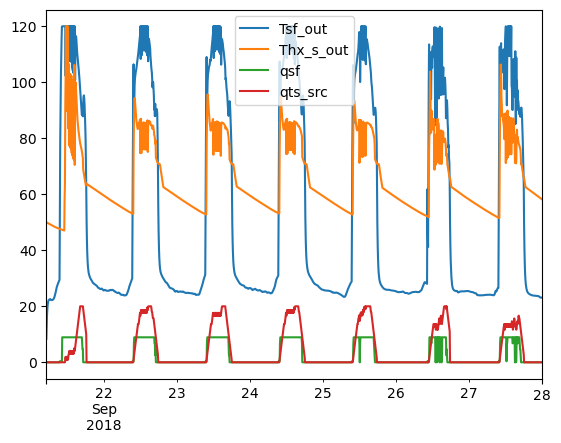

In [ ]:
df_mod[["Tsf_out", "Thx_s_out", "qsf", "qts_src"]].plot()


## Visualize results

In [9]:
# Visualize simulation results

import hjson
from phd_visualizations.test_timeseries import experimental_results_plot
from solarmed_optimization.utils import condition_result_dataframe

vars_config = hjson.load((data_path / "variables_config.hjson").open("r"))
plot_config = hjson.load((data_path / "plot_config_simplified.hjson").open("r"))

df = condition_result_dataframe(df_mod)
plot_config["plots"]["fitness_cumulative"]["title"] = f"Total acummulated benefit: <b>{df['cumulative_net_profit'].iloc[-1]:.2f}</b> (u.m.)"

fig = experimental_results_plot(
    plot_config, 
    df=df, 
    vars_config=vars_config, resample=False
)

fig


In [14]:
from phd_visualizations import save_figure

fig_out_path = output_path.parent / output_path.stem
fig_out_path.mkdir(parents=True, exist_ok=True)

save_figure(
    fig,
    figure_name="results_timeseries",
    figure_path=fig_out_path,
    formats=["html", "png"],
)
